### Libraries

In [25]:
import pandas as pd
import networkx as nx
from pathlib import Path
from fa2 import ForceAtlas2
from nltk import word_tokenize
import matplotlib.pyplot as plt
import community as community_louvain

#### Import scripts

In [26]:
from Scripts.sentiment import sentiment_function
from Scripts.sentiment_VADER import compute_sentiment_VADER

#### Create the directories

In [27]:
Path("Images").mkdir(parents=True, exist_ok=True)
Path("Token_Char").mkdir(parents=True, exist_ok=True)
Path("Images/Networks").mkdir(parents=True, exist_ok=True)
Path("Token_Char/Overall").mkdir(parents=True, exist_ok=True)
Path("Images/Wordclouds/Overall").mkdir(parents=True, exist_ok=True)

#### Load data

In [28]:
data_scenes = pd.read_pickle('Data/Movies.pkl')
data_lines = pd.read_pickle('Data/Dialogues.pkl')

#### Count dialogues between characters

In [29]:
temp_data = data_scenes.reset_index(drop=True)
char_dial = temp_data.apply(lambda x: pd.Series(x['Scene_Characters']),axis=1).stack().reset_index(level=1, drop=True).reset_index()

char_data = pd.DataFrame(columns=list(char_dial[0].unique()))
for char in list(char_dial[0].unique()):
    temp_char_dial = []
    for c_dial in list(char_dial[0].unique()):
        counter = 0
        for scene in range(len(temp_data)):
            if temp_data['Scene_Characters'][scene]!=None:
                if (c_dial in temp_data['Scene_Characters'][scene]) and (char in temp_data['Scene_Characters'][scene]):
                    counter += 1
        temp_char_dial.append(counter)
    char_data.loc[len(char_data)] = temp_char_dial    
char_data.index = list(char_dial[0].unique())

<ipython-input-29-0a268db1d1fd>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  char_dial = temp_data.apply(lambda x: pd.Series(x['Scene_Characters']),axis=1).stack().reset_index(level=1, drop=True).reset_index()


#### Create the network

In [30]:
G = nx.DiGraph()
for temp_char in list(char_dial[0].unique()):
    # Add nodes
    G.add_node(temp_char)
    
    # Add edges
    for char_edge in list(char_dial[0].unique()):
        if (temp_char != char_edge) and (char_data.loc[temp_char, char_edge] != 0):
            G.add_edge(temp_char, char_edge, weight=char_data.loc[temp_char, char_edge]) 

#### Number of nodes

In [31]:
print("Number of nodes in the network:", G.number_of_nodes())

Number of nodes in the network: 223


#### Number of edges

In [32]:
print("Number of links in the network:", G.number_of_edges())

Number of links in the network: 1404


#### Degree network

In [33]:
connections_in = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)
print('In Degree Connections:')
for character, in_degree in connections_in[:10]:
    node = G.nodes[character]
    print(character.ljust(30), 'In-degree:', in_degree)

In Degree Connections:
ANAKIN                         In-degree: 68
OBIWAN                         In-degree: 52
THREEPIO                       In-degree: 51
LUKE                           In-degree: 48
PADME                          In-degree: 41
QUIGON                         In-degree: 35
LEIA                           In-degree: 33
VADER                          In-degree: 32
HAN                            In-degree: 32
JAR JAR                        In-degree: 27


#### Visualize the network

100%|██████████| 1000/1000 [00:01<00:00, 981.62it/s]


BarnesHut Approximation  took  0.25  seconds
Repulsion forces  took  0.65  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


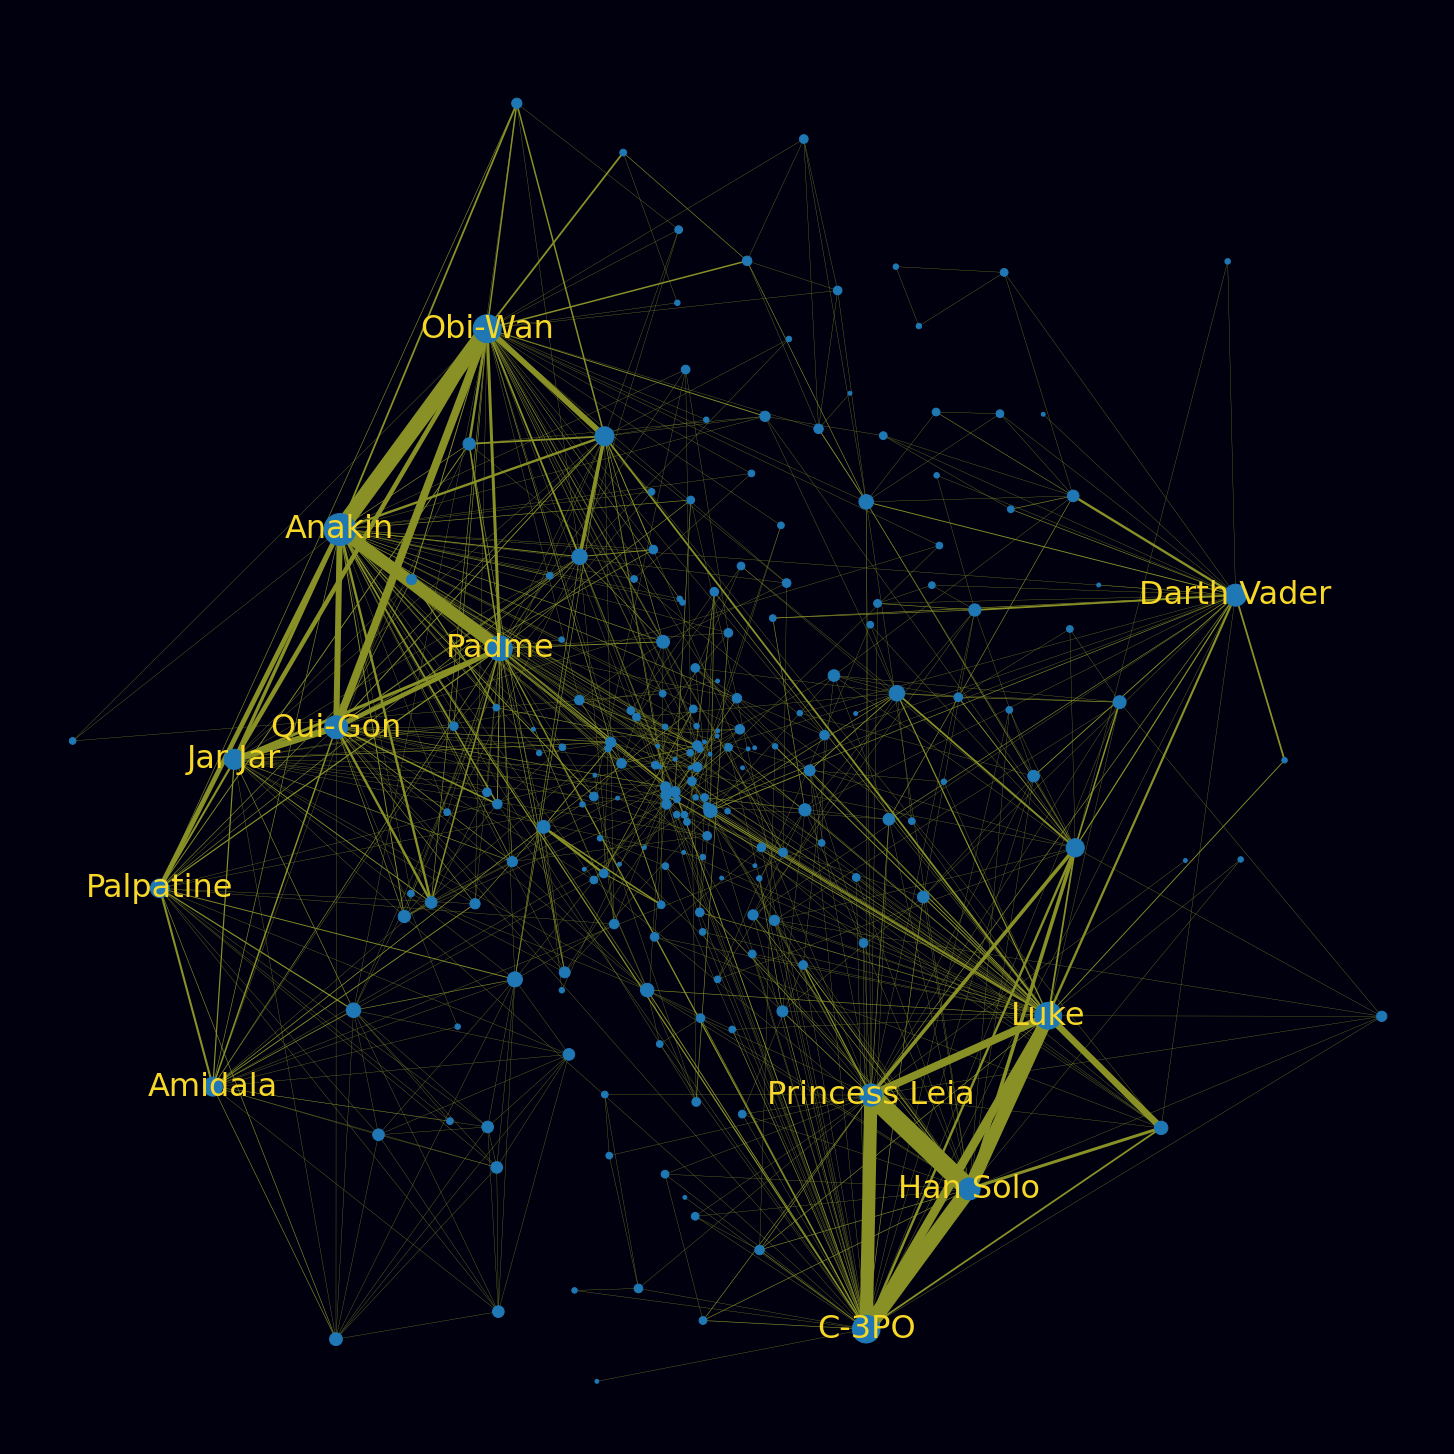

In [34]:
G = G.to_undirected()

forceatlas2 = ForceAtlas2(scalingRatio = 100, gravity = 1000)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

node_sizes = [degree*15 for degree in dict(G.degree()).values()]
edge_sizes = [G[u][v]['weight']*0.3 for u,v in G.edges()]

# Plotting
fig = plt.figure(figsize = (20, 20))
nx.draw(G, pos=positions, node_size=node_sizes, edge_color='#899126', width = edge_sizes)
nx.draw_networkx_labels(G, positions, {"ANAKIN": "Anakin", "QUIGON": "Qui-Gon", 'AMIDALA': 'Amidala',
                                       'OBIWAN':'Obi-Wan', 'PALPATINE':'Palpatine', 'PADME':'Padme',
                                       'JAR JAR':'Jar Jar', 'LUKE':'Luke', 'THREEPIO':'C-3PO', 
                                       'LEIA':'Princess Leia', 'VADER':'Darth Vader', 'HAN':'Han Solo'}, 
                        font_size=32, font_color='#F8D827')

fig.set_facecolor("#00000F")
plt.savefig("Images/Networks/All_Episodes.png", format="PNG")
plt.show()

#### Calculate the nodes with the highest degree centrality

In [35]:
d_centrality = sorted(nx.degree_centrality(G).items(), 
                      key=lambda t: t[1], 
                      reverse=True)

for i in d_centrality[:5]:
    print(i)

('ANAKIN', 0.3063063063063063)
('OBIWAN', 0.23423423423423423)
('THREEPIO', 0.22972972972972971)
('LUKE', 0.21621621621621623)
('PADME', 0.18468468468468469)


#### Calculate number of communities and the value of modularity

In [36]:
partition = community_louvain.best_partition(G)
communities_louvain = [[node for node in partition if partition[node] == cat] for cat in set(partition.values())]
modularity_louvain = nx.algorithms.community.modularity(G,communities_louvain)

print(f'Number of Communities: {len(set(partition.values()))}')
print(f'Value of Modularity: {modularity_louvain}')

Number of Communities: 22
Value of Modularity: 0.5218613049713465


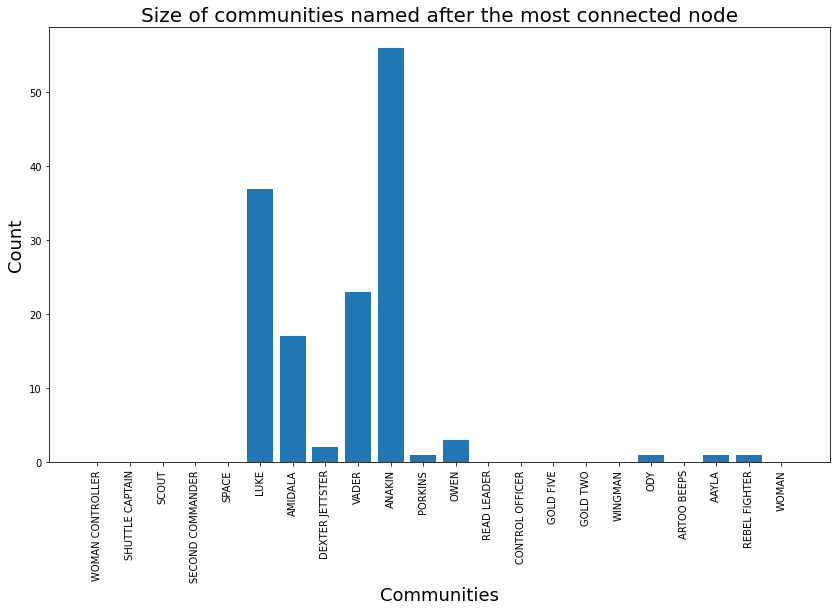

In [37]:
from Scripts.community_name import community_name

node_to_partition_id = community_louvain.best_partition(G)
partition_id_to_name = {partition_id: community_name(G, node_to_partition_id, partition_id) 
                        for partition_id in set(node_to_partition_id.values())}

community_size = {}
for key in partition_id_to_name.keys():
    community_size[partition_id_to_name[key][0][0]] = partition_id_to_name[key][0][1]
    
plt.figure(figsize=(14,8))
plt.bar(*zip(*community_size.items()))
plt.title('Size of communities named after the most connected node', fontsize=20)
plt.xlabel('Communities', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=90)
#plt.savefig("Images/Plots/Dist_Community_Small_Network.png", format="PNG")
plt.show()

#### Read the sentiment of words

In [38]:
LabMT = pd.read_csv('./Files/Data_Set_S1.txt', sep="\t", skiprows = 2)
LabMT_dict = pd.Series(LabMT.happiness_average.values,index=LabMT.word.values).to_dict()

#### Create a list of all the word per scene

In [39]:
words_scene = []
for i, temp_scene in enumerate(temp_data['Scene_Dialogue']):
    string = ''
    if temp_scene != None:
        #temp_scene = temp_scene.reset_index(drop=True)
        for temp_temp_scene in temp_scene:
            if temp_temp_scene != None:
                string += ''.join([elem for elem in temp_temp_scene])
        words_scene.append(string)
    else:
        words_scene.append(temp_data['Scene_Description'][i][0])

#### Create a list of all the words per character

In [47]:
#remove = [node for node,degree in dict(G.degree()).items() if degree < 10]
#G.remove_nodes_from(remove)

temp_lines = data_lines
words_char = {}

for temp_char in temp_lines['Character'].unique():
#for temp_char in list(G.nodes):
    temp_data = temp_lines[temp_lines['Character']==temp_char].reset_index(drop=True)
    string = ''
    for line in temp_data['Line']:
        string += line
    words_char[temp_char] = string

#### Calculate the sentiment for every character

In [48]:
corpus = words_char
tokens = {}
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])
    
sort_sentiment_dict = sorted(sentiment_dict_LabMT.items(),key=lambda x: x[1], reverse = True)
print('Happiest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])
    
sort_sentiment_dict = sorted(sentiment_dict_VADER.items(),key=lambda x: x[1], reverse = True)
print('\nHappiest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])

Happiest Characters (LabMT):
('FIRST CONTROLLER', 6.0)
('SECOND COMMANDER', 6.0)
('REBEL FIGHTER', 5.9)
('GREEN LEADER', 5.875)
('TROOPER VOICE', 5.71)

Saddest Characters (LabMT):
('GUNGAN LOOKOUT', 0)
('ANKAIN', 1.74)
('HEAD CONTROLLER', 2.8449999999999998)
('NAVIGATOR', 2.8833333333333333)
('SEBULBA', 3.2585000000000006)

Happiest Characters (VADER):
('FIRST CONTROLLER', 0.20095)
('SECOND COMMANDER', 0.20095)
('HERMIONE', 0.100475)
('OBIWAM', 0.06364)
('BOUSHH', 0.06282173913043479)

Saddest Characters (VADER):
('ANKAIN', -0.148)
('HOBBIE', -0.08506666666666667)
('WOMAN CONTROLLER', -0.068)
('YWING PILOT', -0.05994666666666667)
('DEAK', -0.056575)


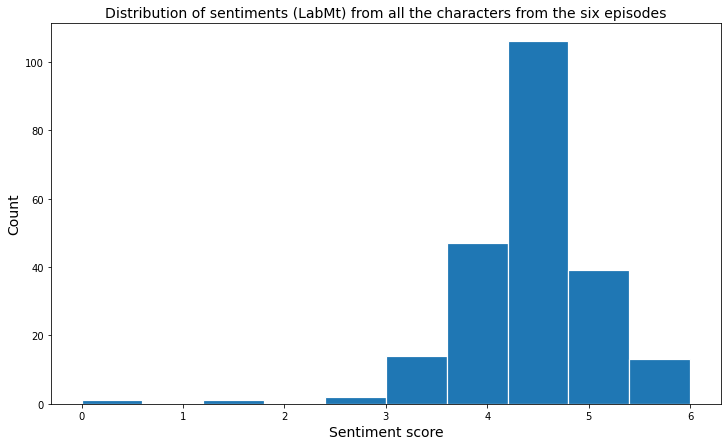

In [50]:
plt.figure(figsize=(12,7))
plt.hist(pd.Series(sentiment_dict_LabMT), edgecolor='white', linewidth=1.2)
plt.title('Distribution of sentiments (LabMt) from all the characters from the six episodes', fontsize =14)
plt.xlabel("Sentiment score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.savefig("Images/Plots/Dist_LabMT_All_Episodes.png", format="PNG")
plt.show()

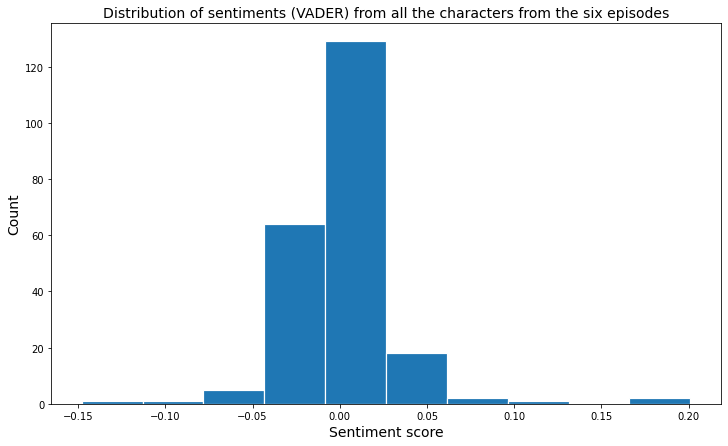

In [51]:
plt.figure(figsize=(12,7))
plt.hist(pd.Series(sentiment_dict_VADER), edgecolor='white', linewidth=1.2)
plt.title('Distribution of sentiments (VADER) from all the characters from the six episodes', fontsize =14)
plt.xlabel("Sentiment score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.savefig("Images/Plots/Dist_VADER_All_Episodes.png", format="PNG")
plt.show()

### Word Clouds

#### Read the sentiment of words

In [37]:
import os
import nltk
import numpy as np
from nltk import FreqDist
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer

#### Create token directory

In [33]:
tk = WordPunctTokenizer()
characters = list(temp_lines['Character'].unique())
for char in characters:
    temp_df = temp_lines[temp_lines['Character']==char].reset_index(drop=True)
    string = ''
    for i in range(len(temp_df)):
        string+=temp_df['Line'][i]
    tokens = tk.tokenize(string)
    tokens = [w.lower() for w in tokens]
    stop_words = stopwords.words('english')
    punctuation = list(punctuation)
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    tokens = [token for token in tokens if token != '...' and char.lower() not in token]
    wnl = nltk.WordNetLemmatizer()
    tokens = [wnl.lemmatize(t) for t in tokens]
    with open('Token_Char/Overall/'+char+'.txt', 'w') as f:
        for item in tokens:
            f.write("%s\n" % item)

#### Calculate TC

In [35]:
tc = {}
root = os.path.join(os.getcwd(), 'Token_Char/Overall')
characters = ['QUIGON', 'ANAKIN', 'OBIWAN', 'PADME', 'PALPATINE', 'YODA',
              'HAN', 'VADER', 'LEIA', 'LUKE', 'LANDO']
for char in characters:
    wordlist = nltk.corpus.PlaintextCorpusReader(root, char + ".txt")
    char_text = nltk.Text(wordlist.words())
    temp_tc = {}
    for key, value in FreqDist(char_text).items():
        temp_tc[key] = value 
    tc[char] = temp_tc

#### Calculate IDF

In [38]:
idf = {}
root = os.path.join(os.getcwd(), 'Token_Char/Overall')
char = [x + '.txt' for x in temp_lines['Character'].unique()]

wordlist = nltk.corpus.PlaintextCorpusReader(root, char)
collection = nltk.TextCollection(wordlist)
for word in np.unique(wordlist.words()):
    idf[word] = collection.idf(word)

#### Calculate TC-IDF

In [39]:
tc_idf = {}
root = os.path.join(os.getcwd(), 'Token_Char/Overall')
characters = ['QUIGON', 'ANAKIN', 'OBIWAN', 'PADME', 'PALPATINE', 'YODA',
              'HAN', 'VADER', 'LEIA', 'LUKE', 'LANDO']
for char in characters:
    temp_tc = tc[char]
    tc_idf_temp = {}
    for (word, value) in temp_tc.items():
        tc_idf_temp[word] = value*idf[word]
    tc_idf[char] = tc_idf_temp

### Print word clouds

In [ ]:
colors = ['Greens', 'Reds', 'Blues', 'GnBu', 'Greys', 'Greens', ]
list_masks = ['Files/Wordcloud/CIRCLE.png', 'Files/Wordcloud/CLOUD2.png',
              'Files/Wordcloud/LEAF.jpg', 'Files/Wordcloud/CIRCLE.png',
              'Files/Wordcloud/CLOUD2.png']

for i, char in enumerate(characters):
    plt.figure(figsize=[20, 20])
    masks = np.array(Image.open(list_masks[i]))
    wordcloud_race = WordCloud(colormap= colors[i], background_color='white', mask=masks)
    wordcloud_race.generate_from_frequencies(tc_idf[char])
    plt.subplot(3, 2, i+1)
    plt.imshow(wordcloud_race, interpolation='bilinear')
    plt.axis("off")
    plt.title(char)
    #plt.savefig('./Images/Wordclouds/Episode_I/'+char+'.png')
    plt.show()

## Split into Trilogies

### First Trilogy

#### Count dialogues between characters

In [52]:
temp_data = data_scenes[(data_scenes['Movie']=='Episode I') | (data_scenes['Movie']=='Episode II') | (data_scenes['Movie']=='Episode III')].reset_index(drop=True)
char_dial = temp_data.apply(lambda x: pd.Series(x['Scene_Characters']),axis=1).stack().reset_index(level=1, drop=True).reset_index()

char_data = pd.DataFrame(columns=list(char_dial[0].unique()))
for char in list(char_dial[0].unique()):
    temp_char_dial = []
    for c_dial in list(char_dial[0].unique()):
        counter = 0
        for scene in range(len(temp_data)):
            if temp_data['Scene_Characters'][scene]!=None:
                if (c_dial in temp_data['Scene_Characters'][scene]) and (char in temp_data['Scene_Characters'][scene]):
                    counter += 1
        temp_char_dial.append(counter)
    char_data.loc[len(char_data)] = temp_char_dial    
char_data.index = list(char_dial[0].unique())

<ipython-input-52-6bd15483fe2f>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  char_dial = temp_data.apply(lambda x: pd.Series(x['Scene_Characters']),axis=1).stack().reset_index(level=1, drop=True).reset_index()


#### Create the network

In [53]:
G = nx.DiGraph()
for temp_char in list(char_dial[0].unique()):
    # Add nodes
    G.add_node(temp_char)
    
    # Add edges
    for char_edge in list(char_dial[0].unique()):
        if (temp_char != char_edge) and (char_data.loc[temp_char, char_edge] != 0):
            G.add_edge(temp_char, char_edge, weight=char_data.loc[temp_char, char_edge]) 

#### Number of nodes

In [54]:
print("Number of nodes in the network:", G.number_of_nodes())

Number of nodes in the network: 115


#### Number of edges

In [55]:
print("Number of links in the network:", G.number_of_edges())

Number of links in the network: 780


#### Degree network

In [56]:
connections_in = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)
print('In Degree Connections:')
for character, in_degree in connections_in[:10]:
    node = G.nodes[character]
    print(character.ljust(30), 'In-degree:', in_degree)

In Degree Connections:
ANAKIN                         In-degree: 65
OBIWAN                         In-degree: 52
PADME                          In-degree: 41
QUIGON                         In-degree: 35
JAR JAR                        In-degree: 27
AMIDALA                        In-degree: 24
PALPATINE                      In-degree: 23
YODA                           In-degree: 22
MACE WINDU                     In-degree: 16
BAIL ORGANA                    In-degree: 15


#### Visualize the network

100%|██████████| 1000/1000 [00:00<00:00, 2449.13it/s]


BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.25  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


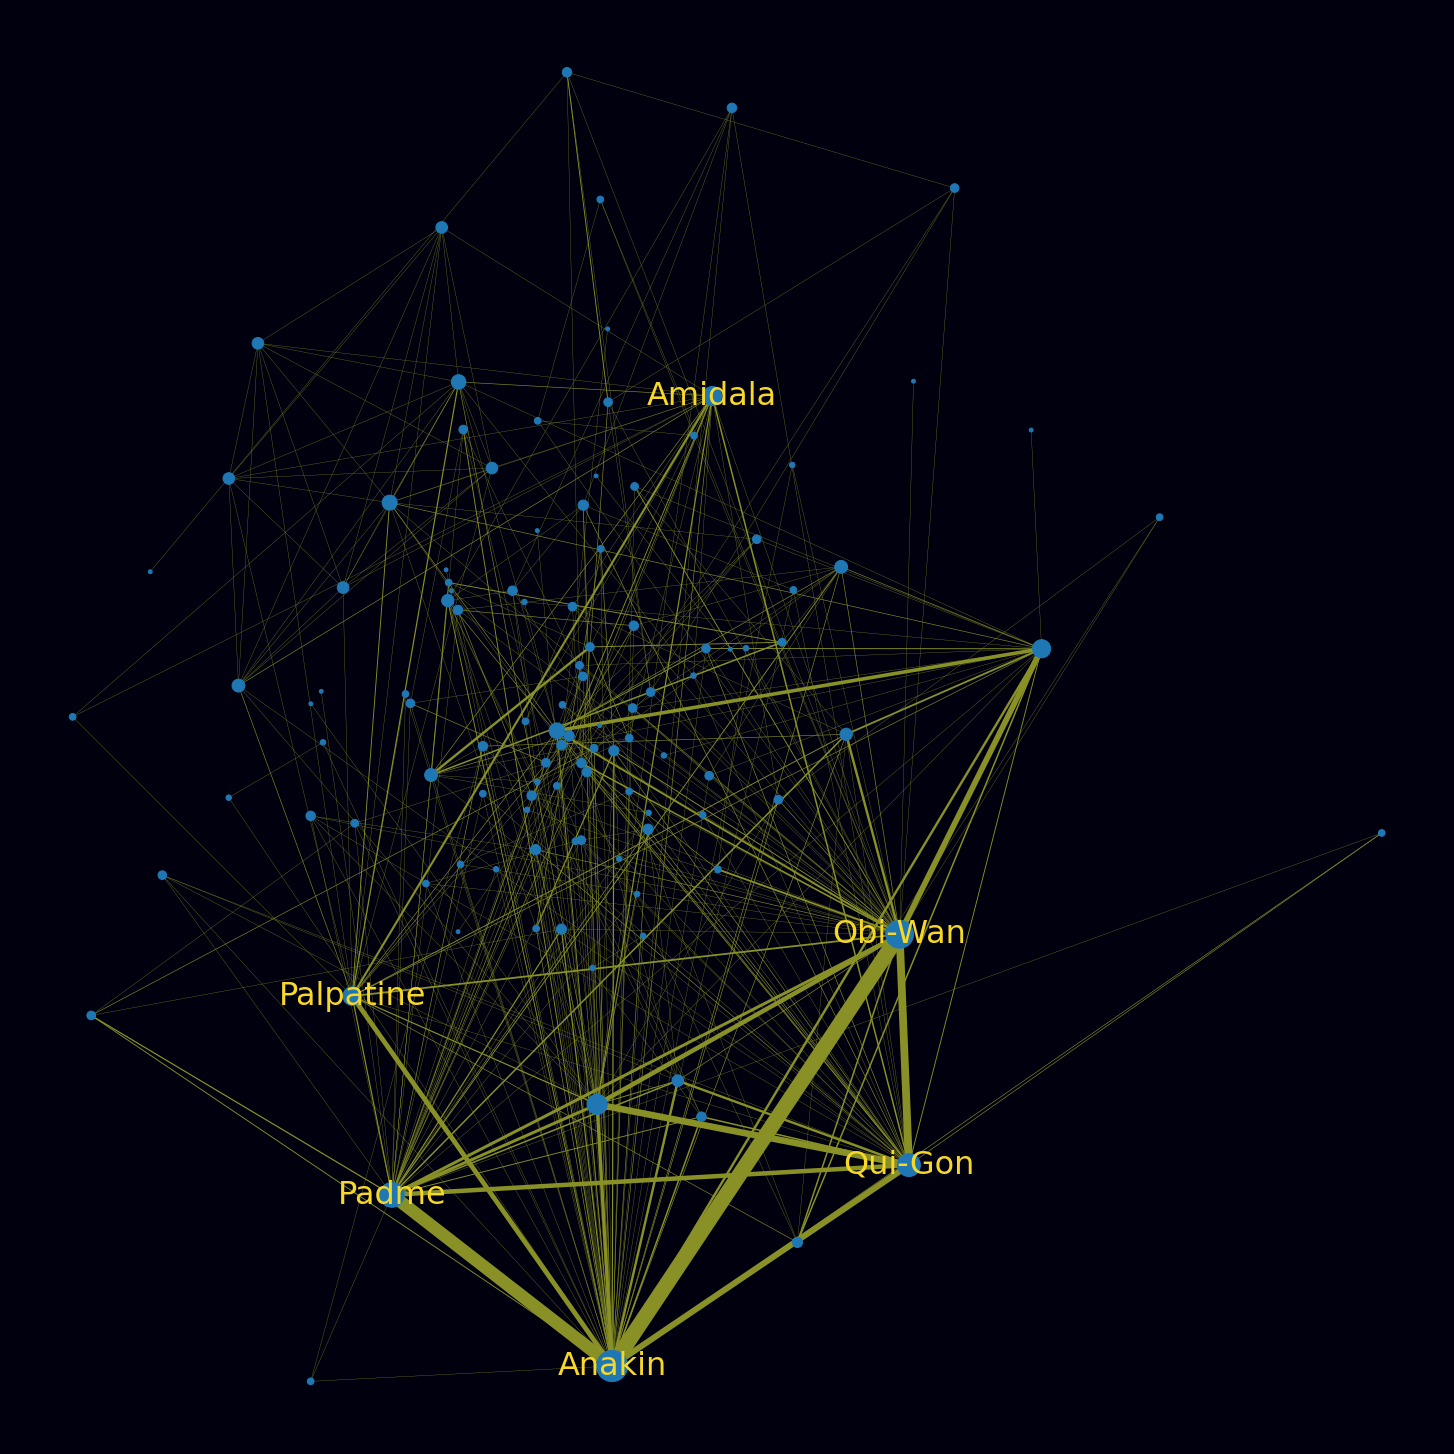

In [57]:
G = G.to_undirected()

forceatlas2 = ForceAtlas2(scalingRatio = 100, gravity = 1000)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

node_sizes = [degree*15 for degree in dict(G.degree()).values()]
edge_sizes = [G[u][v]['weight']*0.3 for u,v in G.edges()]

# Plotting
fig = plt.figure(figsize = (20, 20))
nx.draw(G, pos=positions, node_size=node_sizes, edge_color='#899126', width = edge_sizes)
nx.draw_networkx_labels(G, positions, {"ANAKIN": "Anakin", "QUIGON": "Qui-Gon", 'AMIDALA': 'Amidala',
                                       'OBIWAN':'Obi-Wan', 'PALPATINE':'Palpatine', 'PADME':'Padme',}, 
                        font_size=32, font_color='#F8D827')

fig.set_facecolor("#00000F")
plt.savefig("Images/Networks/First_Trilogy.png", format="PNG")
plt.show()

#### Calculate the nodes with the highest degree centrality

In [58]:
d_centrality = sorted(nx.degree_centrality(G).items(), 
                      key=lambda t: t[1], 
                      reverse=True)

for i in d_centrality[:5]:
    print(i)

('ANAKIN', 0.5701754385964912)
('OBIWAN', 0.45614035087719296)
('PADME', 0.35964912280701755)
('QUIGON', 0.3070175438596491)
('JAR JAR', 0.23684210526315788)


#### Calculate number of communities and the value of modularity

In [59]:
partition = community_louvain.best_partition(G)
communities_louvain = [[node for node in partition if partition[node] == cat] for cat in set(partition.values())]
modularity_louvain = nx.algorithms.community.modularity(G,communities_louvain)

print(f'Number of Communities: {len(set(partition.values()))}')
print(f'Value of Modularity: {modularity_louvain}')

Number of Communities: 10
Value of Modularity: 0.3208598345685829


#### Create a list of all the word per scene

In [60]:
words_scene = []
for i, temp_scene in enumerate(temp_data['Scene_Dialogue']):
    string = ''
    if temp_scene != None:
        #temp_scene = temp_scene.reset_index(drop=True)
        for temp_temp_scene in temp_scene:
            if temp_temp_scene != None:
                string += ''.join([elem for elem in temp_temp_scene])
        words_scene.append(string)
    else:
        words_scene.append(temp_data['Scene_Description'][i][0])

#### Calculate the sentiment up until the scene

In [61]:
corpus = {}
tokens = {}
for scene_number, scene in enumerate(words_scene):
    if scene_number == 0:
        corpus[scene_number] = scene 
    else:
        corpus[scene_number] = corpus[scene_number-1] + scene 
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])

#### Sentiment score of the first trilogy

In [62]:
print('LabMT Sentiment Score for the Movie: {:.5f}'.format(sentiment_dict_LabMT[len(sentiment_dict_LabMT)-1]))
print('VADER Sentiment Score for the Movie: {:.5f}'.format(sentiment_dict_VADER[len(sentiment_dict_VADER)-1]))

LabMT Sentiment Score for the Movie: 2.86599
VADER Sentiment Score for the Movie: -0.00301


#### Create a list of all the words per character

In [63]:
temp_lines = data_lines[(data_lines['Movie']=='Episode I') | (data_lines['Movie']=='Episode II') | (data_lines['Movie']=='Episode III')]
words_char = {}

for temp_char in temp_lines['Character'].unique():
    temp_data = temp_lines[temp_lines['Character']==temp_char].reset_index(drop=True)
    string = ''
    for line in temp_data['Line']:
        string += line
    words_char[temp_char] = string

#### Calculate the sentiment for every character

In [64]:
corpus = words_char
tokens = {}
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])
    
sort_sentiment_dict = sorted(sentiment_dict_LabMT.items(),key=lambda x: x[1], reverse = True)
print('Happiest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])
    
sort_sentiment_dict = sorted(sentiment_dict_VADER.items(),key=lambda x: x[1], reverse = True)
print('\nHappiest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])

Happiest Characters (LabMT):
('BERU', 7.0)
('GREEDO', 6.74)
('HERMIONE', 5.709999999999999)
('ANAKINN', 5.63)
('BOBA', 5.505)

Saddest Characters (LabMT):
('GUNGAN LOOKOUT', 0)
('ANKAIN', 1.74)
('JABBA', 2.7060526315789475)
('SEBULBA', 3.2585000000000006)
('ODY', 3.366027397260273)

Happiest Characters (VADER):
('GREEDO', 0.4019)
('HERMIONE', 0.100475)
('CREATURE', 0.06774705882352941)
('OBIWAM', 0.06364)
('LAMA SU', 0.05519245283018868)

Saddest Characters (VADER):
('ANKAIN', -0.148)
('PAMDE', -0.05411666666666667)
('ZAM WESSEL', -0.04697)
('ELAN SLEAZEBAGGANO', -0.03996)
('TEY HOW', -0.039185)


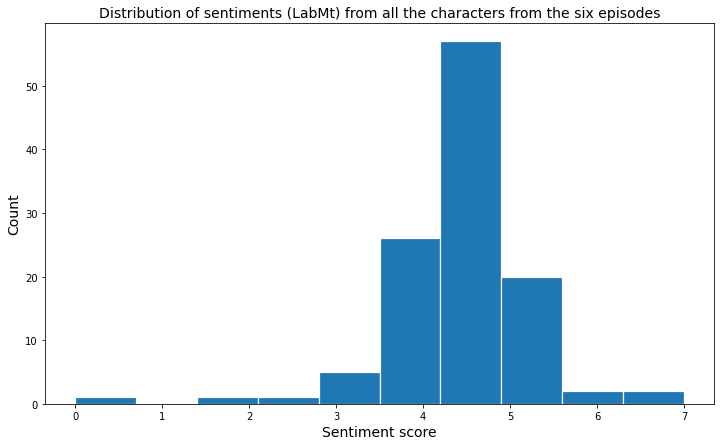

In [68]:
plt.figure(figsize=(12,7))
plt.hist(pd.Series(sentiment_dict_LabMT), edgecolor='white', linewidth=1.2)
plt.title('Distribution of sentiments (LabMt) from all the characters from the six episodes', fontsize =14)
plt.xlabel("Sentiment score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.savefig("Images/Plots/Dist_LabMT_First.png", format="PNG")
plt.show()

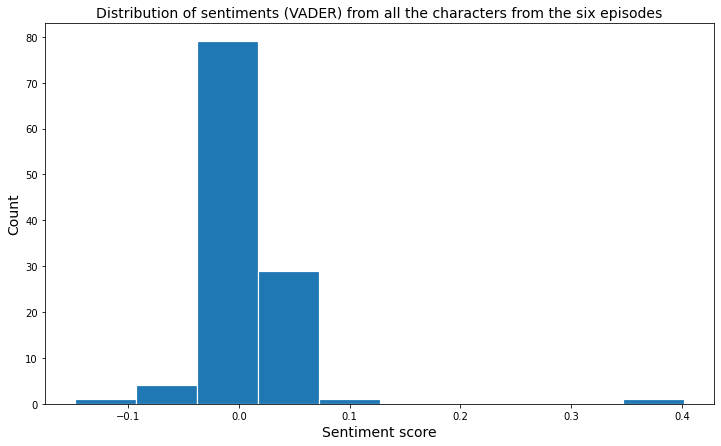

In [69]:
plt.figure(figsize=(12,7))
plt.hist(pd.Series(sentiment_dict_VADER), edgecolor='white', linewidth=1.2)
plt.title('Distribution of sentiments (VADER) from all the characters from the six episodes', fontsize =14)
plt.xlabel("Sentiment score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.savefig("Images/Plots/Dist_VADER_First.png", format="PNG")
plt.show()

### Second Trilogy

#### Count dialogues between characters

In [70]:
temp_data = data_scenes[(data_scenes['Movie']=='Episode IV') | (data_scenes['Movie']=='Episode V') | (data_scenes['Movie']=='Episode VI')].reset_index(drop=True)
char_dial = temp_data.apply(lambda x: pd.Series(x['Scene_Characters']),axis=1).stack().reset_index(level=1, drop=True).reset_index()

char_data = pd.DataFrame(columns=list(char_dial[0].unique()))
for char in list(char_dial[0].unique()):
    temp_char_dial = []
    for c_dial in list(char_dial[0].unique()):
        counter = 0
        for scene in range(len(temp_data)):
            if temp_data['Scene_Characters'][scene]!=None:
                if (c_dial in temp_data['Scene_Characters'][scene]) and (char in temp_data['Scene_Characters'][scene]):
                    counter += 1
        temp_char_dial.append(counter)
    char_data.loc[len(char_data)] = temp_char_dial    
char_data.index = list(char_dial[0].unique())

<ipython-input-70-50adc2ee4891>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  char_dial = temp_data.apply(lambda x: pd.Series(x['Scene_Characters']),axis=1).stack().reset_index(level=1, drop=True).reset_index()


#### Create the network

In [71]:
G = nx.DiGraph()
for temp_char in list(char_dial[0].unique()):
    # Add nodes
    G.add_node(temp_char)
    
    # Add edges
    for char_edge in list(char_dial[0].unique()):
        if (temp_char != char_edge) and (char_data.loc[temp_char, char_edge] != 0):
            G.add_edge(temp_char, char_edge, weight=char_data.loc[temp_char, char_edge]) 

#### Number of nodes

In [72]:
print("Number of nodes in the network:", G.number_of_nodes())

Number of nodes in the network: 120


#### Number of edges

In [73]:
print("Number of links in the network:", G.number_of_edges())

Number of links in the network: 630


#### Degree network

In [74]:
connections_in = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)
print('In Degree Connections:')
for character, in_degree in connections_in[:10]:
    node = G.nodes[character]
    print(character.ljust(30), 'In-degree:', in_degree)

In Degree Connections:
LUKE                           In-degree: 48
THREEPIO                       In-degree: 45
LEIA                           In-degree: 33
VADER                          In-degree: 32
HAN                            In-degree: 32
LANDO                          In-degree: 22
WEDGE                          In-degree: 16
BIGGS                          In-degree: 12
BEN                            In-degree: 12
ACKBAR                         In-degree: 11


#### Visualize the network

100%|██████████| 1000/1000 [00:00<00:00, 1871.15it/s]


BarnesHut Approximation  took  0.12  seconds
Repulsion forces  took  0.32  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


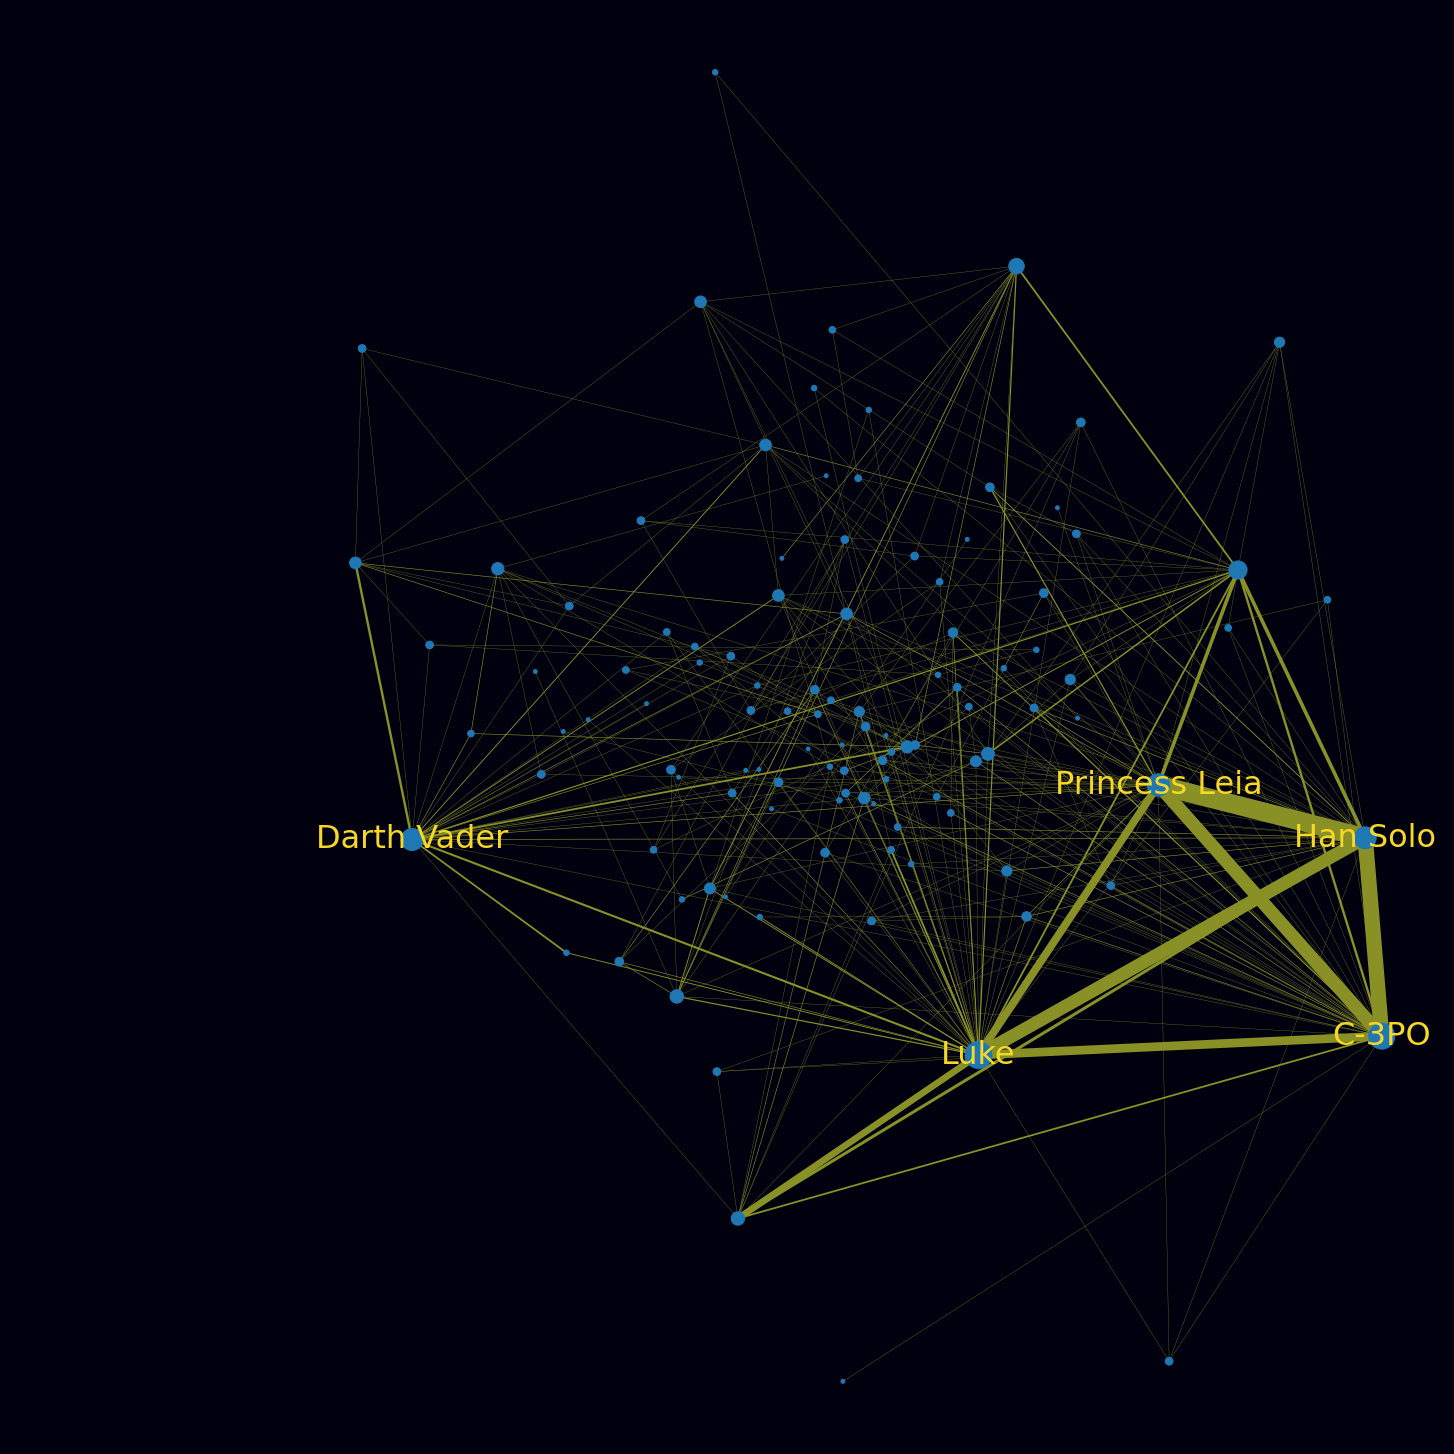

In [75]:
G = G.to_undirected()

forceatlas2 = ForceAtlas2(scalingRatio = 100, gravity = 1000)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

node_sizes = [degree*15 for degree in dict(G.degree()).values()]
edge_sizes = [G[u][v]['weight']*0.3 for u,v in G.edges()]

# Plotting
fig = plt.figure(figsize = (20, 20))
nx.draw(G, pos=positions, node_size=node_sizes, edge_color='#899126', width = edge_sizes)
nx.draw_networkx_labels(G, positions, {'LUKE':'Luke', 'THREEPIO':'C-3PO', 
                                       'LEIA':'Princess Leia', 'VADER':'Darth Vader', 'HAN':'Han Solo'}, 
                        font_size=32, font_color='#F8D827')

fig.set_facecolor("#00000F")
plt.savefig("Images/Networks/Second_Trilogy.png", format="PNG")
plt.show()

#### Calculate the nodes with the highest degree centrality

In [76]:
d_centrality = sorted(nx.degree_centrality(G).items(), 
                      key=lambda t: t[1], 
                      reverse=True)

for i in d_centrality[:5]:
    print(i)

('LUKE', 0.40336134453781514)
('THREEPIO', 0.37815126050420167)
('LEIA', 0.2773109243697479)
('VADER', 0.2689075630252101)
('HAN', 0.2689075630252101)


#### Calculate number of communities and the value of modularity

In [77]:
partition = community_louvain.best_partition(G)
communities_louvain = [[node for node in partition if partition[node] == cat] for cat in set(partition.values())]
modularity_louvain = nx.algorithms.community.modularity(G,communities_louvain)

print(f'Number of Communities: {len(set(partition.values()))}')
print(f'Value of Modularity: {modularity_louvain}')

Number of Communities: 18
Value of Modularity: 0.3315020718048372


#### Create a list of all the word per scene

In [78]:
words_scene = []
for i, temp_scene in enumerate(temp_data['Scene_Dialogue']):
    string = ''
    if temp_scene != None:
        #temp_scene = temp_scene.reset_index(drop=True)
        for temp_temp_scene in temp_scene:
            if temp_temp_scene != None:
                string += ''.join([elem for elem in temp_temp_scene])
        words_scene.append(string)
    else:
        words_scene.append(temp_data['Scene_Description'][i][0])

#### Calculate the sentiment up until the scene

In [79]:
corpus = {}
tokens = {}
for scene_number, scene in enumerate(words_scene):
    if scene_number == 0:
        corpus[scene_number] = scene 
    else:
        corpus[scene_number] = corpus[scene_number-1] + scene 
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])

#### Sentiment score of the second trilogy

In [80]:
print('LabMT Sentiment Score for the Movie: {:.5f}'.format(sentiment_dict_LabMT[len(sentiment_dict_LabMT)-1]))
print('VADER Sentiment Score for the Movie: {:.5f}'.format(sentiment_dict_VADER[len(sentiment_dict_VADER)-1]))

LabMT Sentiment Score for the Movie: 2.83683
VADER Sentiment Score for the Movie: -0.00733


#### Create a list of all the words per character

In [81]:
temp_lines = data_lines[(data_lines['Movie']=='Episode IV') | (data_lines['Movie']=='Episode V') | (data_lines['Movie']=='Episode VI')]
words_char = {}

for temp_char in temp_lines['Character'].unique():
    temp_data = temp_lines[temp_lines['Character']==temp_char].reset_index(drop=True)
    string = ''
    for line in temp_data['Line']:
        string += line
    words_char[temp_char] = string

#### Calculate the sentiment for every character

In [82]:
corpus = words_char
tokens = {}
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])
    
sort_sentiment_dict = sorted(sentiment_dict_LabMT.items(),key=lambda x: x[1], reverse = True)
print('Happiest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])
    
sort_sentiment_dict = sorted(sentiment_dict_VADER.items(),key=lambda x: x[1], reverse = True)
print('\nHappiest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])

Happiest Characters (LabMT):
('FIRST CONTROLLER', 6.0)
('SECOND COMMANDER', 6.0)
('REBEL FIGHTER', 5.9)
('GREEN LEADER', 5.875)
('TROOPER VOICE', 5.71)

Saddest Characters (LabMT):
('HEAD CONTROLLER', 2.8449999999999998)
('NAVIGATOR', 2.8833333333333333)
('BIB', 3.3398387096774194)
('OOLA', 3.3425)
('DAY', 3.442424242424243)

Happiest Characters (VADER):
('FIRST CONTROLLER', 0.20095)
('SECOND COMMANDER', 0.20095)
('BOUSHH', 0.06282173913043479)
('PILOTS', 0.056575)
('JERJERROD', 0.04279428571428571)

Saddest Characters (VADER):
('HOBBIE', -0.08506666666666667)
('WOMAN CONTROLLER', -0.068)
('YWING PILOT', -0.05994666666666667)
('DEAK', -0.056575)
('CONTROLLER', -0.04298571428571429)


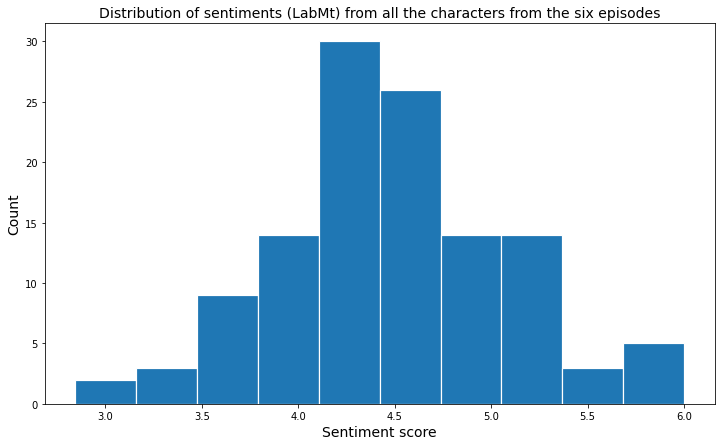

In [85]:
plt.figure(figsize=(12,7))
plt.hist(pd.Series(sentiment_dict_LabMT), edgecolor='white', linewidth=1.2)
plt.title('Distribution of sentiments (LabMt) from all the characters from the six episodes', fontsize =14)
plt.xlabel("Sentiment score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.savefig("Images/Plots/Dist_LabMT_Second.png", format="PNG")
plt.show()

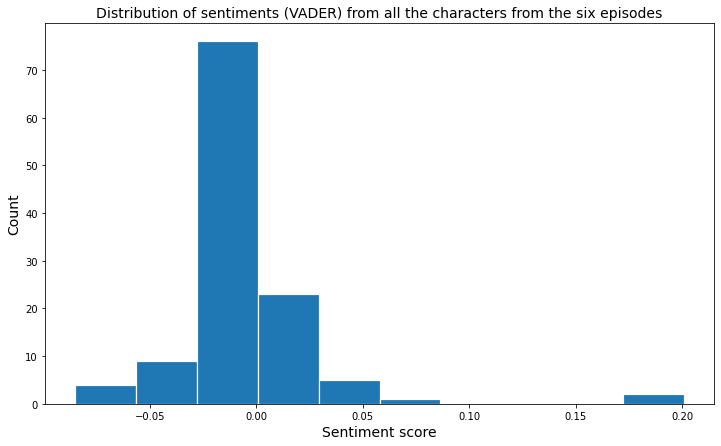

In [86]:
plt.figure(figsize=(12,7))
plt.hist(pd.Series(sentiment_dict_VADER), edgecolor='white', linewidth=1.2)
plt.title('Distribution of sentiments (VADER) from all the characters from the six episodes', fontsize =14)
plt.xlabel("Sentiment score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.savefig("Images/Plots/Dist_VADER_Second.png", format="PNG")
plt.show()